In [1]:
#tensorflow 버전 확인
import tensorflow as tf
print(tf.__version__)

2.6.0


In [2]:
# device list에 GPU있나 확인
from tensorflow.python.client import device_lib

print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 17698142836551618095
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 7799308288
locality {
  bus_id: 1
  links {
  }
}
incarnation: 498925540330212900
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3080, pci bus id: 0000:01:00.0, compute capability: 8.6"
]


In [3]:
#라이브러리 설치
!pip install transformers
!pip install keras==2.6

!pip install scikit-learn

#필요한 모듈 불러오기
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertForSequenceClassification

from sklearn.model_selection import train_test_split

import numpy as np
import pandas as pd

from tabulate import tabulate
from tqdm import trange
import random
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')


print("GPU available:",torch.cuda.is_available())

GPU available: True


In [4]:
# 내 깃허브 폴더에서 리뷰 데이터 불러와서 dataframe으로 저장
# Food 속성 리뷰
url='https://raw.githubusercontent.com/Eunjin3395/graduation_project/main/data/food_total.csv'
df = pd.read_csv(url,sep=',', header=0, encoding_errors='ignore')
df.head(5)

,id,text,category,polarity
0,2777,"To be completely fair, the only redeeming fact...",food,1
1,1634,"The food is uniformly exceptional, with a very...",food,1
2,2846,"Not only was the food outstanding, but the lit...",food,1
3,1571,It is very overpriced and not very tasty.,food,0
4,1458,Our agreed favorite is the orrechiete with sau...,food,1


In [5]:
df.dtypes

id          object
text        object
category    object
polarity     int64
dtype: object

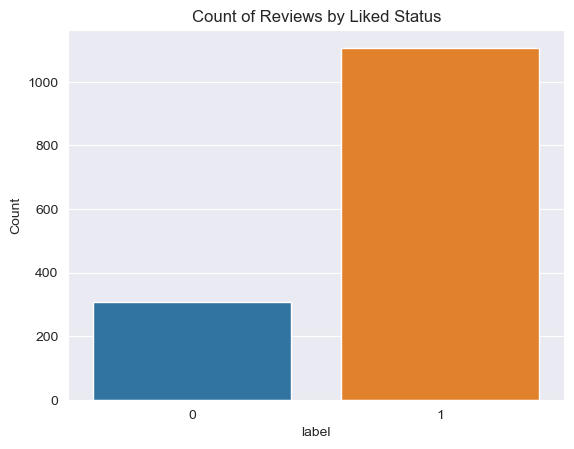

In [6]:
# review data의 label 분포
sns.set_style('darkgrid')

# Create a count plot of the "Liked" column
sns.countplot(x='polarity', data=df)

# Set the title of the plot
plt.title('Count of Reviews by Liked Status')

# Set the label for the x-axis
plt.xlabel('label')

# Set the label for the y-axis
plt.ylabel('Count')

# Show the plot
plt.show()

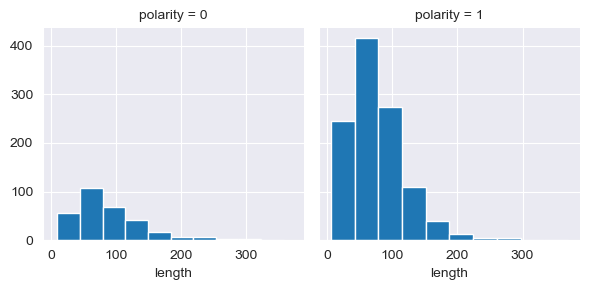

In [7]:
# review data의 길이 분포 및 통계
df_new=df
df_new['length'] = df['text'].apply(len)

# Create a FacetGrid object with 'Liked' as the column to be used for separating the data
# FacetGrid is a grid of subplots that displays the same relationship between different subsets of your data.
g = sns.FacetGrid(df, col='polarity')

# Use the FacetGrid object to plot a histogram of the 'Length' column for each value of 'Liked'
g.map(plt.hist, 'length');

In [8]:
df_new.length.describe()

count    1415.000000
mean       79.168198
std        46.640079
min         6.000000
25%        47.500000
50%        70.000000
75%       102.000000
max       370.000000
Name: length, dtype: float64

In [9]:
text = df.text.values
labels = df.polarity.values

In [10]:
# 전처리
tokenizer = BertTokenizer.from_pretrained(
    'bert-base-uncased',
    do_lower_case = True
    )

In [11]:
MAX_LENGTH=370
token_id = []
attention_masks = []

def preprocessing(input_text, tokenizer):
  '''
  Returns <class transformers.tokenization_utils_base.BatchEncoding> with the following fields:
    - input_ids: list of token ids
    - token_type_ids: list of token type ids
    - attention_mask: list of indices (0,1) specifying which tokens should considered by the model (return_attention_mask = True).
  '''
  return tokenizer.encode_plus(
                        input_text,
                        add_special_tokens = True,
                        max_length = MAX_LENGTH,
                        pad_to_max_length = True,
                        return_attention_mask = True,
                        return_tensors = 'pt',
                        truncation=True
                   )


for sample in text:
  encoding_dict = preprocessing(sample, tokenizer)

  # token_id 리스트 추출
  token_id.append(encoding_dict['input_ids']) 
  # attention_mask 리스트 추출
  attention_masks.append(encoding_dict['attention_mask'])


# 리스트를 텐서로
token_id = torch.cat(token_id, dim = 0)
attention_masks = torch.cat(attention_masks, dim = 0)
labels = torch.tensor(labels)

In [12]:
VAL_RATIO= 0.2
batch_size = 8 # 16 or 32 추천이라고 한다

# Indices of the train and validation splits stratified by labels
train_idx, val_idx = train_test_split(
    np.arange(len(labels)),
    test_size = VAL_RATIO,
    shuffle = True,
    stratify = labels)

# Train and validation sets
train_set = TensorDataset(token_id[train_idx], 
                          attention_masks[train_idx], 
                          labels[train_idx])

val_set = TensorDataset(token_id[val_idx], 
                        attention_masks[val_idx], 
                        labels[val_idx])

# Prepare DataLoader
train_dataloader = DataLoader(
            train_set,
            sampler = RandomSampler(train_set),
            batch_size = batch_size
        )

validation_dataloader = DataLoader(
            val_set,
            sampler = SequentialSampler(val_set),
            batch_size = batch_size
        )


print("train: {}".format(len(train_idx)))
print("validation: {}".format(len(val_idx)))


train: 1132
validation: 283


In [13]:

def b_tp(preds, labels):
  '''Returns True Positives (TP): count of correct predictions of actual class 1'''
  return sum([preds == labels and preds == 1 for preds, labels in zip(preds, labels)])

def b_fp(preds, labels):
  '''Returns False Positives (FP): count of wrong predictions of actual class 1'''
  return sum([preds != labels and preds == 1 for preds, labels in zip(preds, labels)])

def b_tn(preds, labels):
  '''Returns True Negatives (TN): count of correct predictions of actual class 0'''
  return sum([preds == labels and preds == 0 for preds, labels in zip(preds, labels)])

def b_fn(preds, labels):
  '''Returns False Negatives (FN): count of wrong predictions of actual class 0'''
  return sum([preds != labels and preds == 0 for preds, labels in zip(preds, labels)])

def b_metrics(preds, labels):
  '''
  Returns the following metrics:
    - accuracy    = (TP + TN) / N
    - precision   = TP / (TP + FP)
    - recall      = TP / (TP + FN)
    - specificity = TN / (TN + FP)
  '''
  preds = np.argmax(preds, axis = 1).flatten()
  labels = labels.flatten()
  tp = b_tp(preds, labels)
  tn = b_tn(preds, labels)
  fp = b_fp(preds, labels)
  fn = b_fn(preds, labels)
  b_accuracy = (tp + tn) / len(labels)
  b_precision = tp / (tp + fp) if (tp + fp) > 0 else 'nan'
  b_recall = tp / (tp + fn) if (tp + fn) > 0 else 'nan'
  b_specificity = tn / (tn + fp) if (tn + fp) > 0 else 'nan'
  return b_accuracy, b_precision, b_recall, b_specificity

In [14]:
# BERT 모델 불러오기
model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels = 2,
    output_attentions = False,
    output_hidden_states = False,
)


optimizer = torch.optim.AdamW(model.parameters(), 
                              lr = 5e-5, # learning rate 설정
                              eps = 1e-08
                              )

model.cuda()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [15]:
# GPU로 학습하도록 설정
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 학습 횟수 설정
epochs = 10

idx=0
epo_list=[]
train_loss_list=[]
val_accuracy_list=[]

for _ in trange(epochs, desc = 'Epoch'):
    idx+=1
    epo_list.append(idx)

    # ========== Training ==========
    model.train()
    
    # Tracking variables
    tr_loss = 0
    nb_tr_examples, nb_tr_steps = 0, 0

    for step, batch in enumerate(train_dataloader):
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        optimizer.zero_grad()
        # Forward pass
        train_output = model(b_input_ids, 
                             token_type_ids = None, 
                             attention_mask = b_input_mask, 
                             labels = b_labels)
        # Backward pass
        train_output.loss.backward()
        optimizer.step()
        # Update tracking variables
        tr_loss += train_output.loss.item()
        nb_tr_examples += b_input_ids.size(0)
        nb_tr_steps += 1

    # ========== Validation ==========
    model.eval()

    # Tracking variables 
    val_accuracy = []
    val_precision = []
    val_recall = []
    val_specificity = []

    for batch in validation_dataloader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        with torch.no_grad():
          # Forward pass
          eval_output = model(b_input_ids, 
                              token_type_ids = None, 
                              attention_mask = b_input_mask)
        logits = eval_output.logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        # Calculate validation metrics
        b_accuracy, b_precision, b_recall, b_specificity = b_metrics(logits, label_ids)
        val_accuracy.append(b_accuracy)
        # Update precision only when (tp + fp) !=0; ignore nan
        if b_precision != 'nan': val_precision.append(b_precision)
        # Update recall only when (tp + fn) !=0; ignore nan
        if b_recall != 'nan': val_recall.append(b_recall)
        # Update specificity only when (tn + fp) !=0; ignore nan
        if b_specificity != 'nan': val_specificity.append(b_specificity)

    print('\n\t - Train loss: {:.4f}'.format(tr_loss / nb_tr_steps))
    print('\t - Validation Accuracy: {:.4f}'.format(sum(val_accuracy)/len(val_accuracy)))
    val_accuracy_temp=sum(val_accuracy)/len(val_accuracy)
    train_loss_list.append(round(tr_loss / nb_tr_steps,4))
    val_accuracy_list.append(round(val_accuracy_temp,4))
    #print('\t - Validation Precision: {:.4f}'.format(sum(val_precision)/len(val_precision)) if len(val_precision)>0 else '\t - Validation Precision: NaN')
    #print('\t - Validation Recall: {:.4f}'.format(sum(val_recall)/len(val_recall)) if len(val_recall)>0 else '\t - Validation Recall: NaN')
    #print('\t - Validation Specificity: {:.4f}\n'.format(sum(val_specificity)/len(val_specificity)) if len(val_specificity)>0 else '\t - Validation Specificity: NaN')


Epoch:  10%|███████▌                                                                    | 1/10 [00:25<03:50, 25.64s/it]


	 - Train loss: 0.3345
	 - Validation Accuracy: 0.9097


Epoch:  20%|███████████████▏                                                            | 2/10 [00:49<03:14, 24.33s/it]


	 - Train loss: 0.1465
	 - Validation Accuracy: 0.9236


Epoch:  30%|██████████████████████▊                                                     | 3/10 [01:12<02:48, 24.09s/it]


	 - Train loss: 0.0806
	 - Validation Accuracy: 0.8993


Epoch:  40%|██████████████████████████████▍                                             | 4/10 [01:36<02:23, 23.86s/it]


	 - Train loss: 0.0710
	 - Validation Accuracy: 0.9062


Epoch:  50%|██████████████████████████████████████                                      | 5/10 [01:59<01:58, 23.74s/it]


	 - Train loss: 0.0400
	 - Validation Accuracy: 0.9132


Epoch:  60%|█████████████████████████████████████████████▌                              | 6/10 [02:23<01:34, 23.67s/it]


	 - Train loss: 0.0180
	 - Validation Accuracy: 0.9201


Epoch:  70%|█████████████████████████████████████████████████████▏                      | 7/10 [02:46<01:10, 23.63s/it]


	 - Train loss: 0.0170
	 - Validation Accuracy: 0.8819


Epoch:  80%|████████████████████████████████████████████████████████████▊               | 8/10 [03:10<00:47, 23.61s/it]


	 - Train loss: 0.0202
	 - Validation Accuracy: 0.8958


Epoch:  90%|████████████████████████████████████████████████████████████████████▍       | 9/10 [03:34<00:23, 23.67s/it]


	 - Train loss: 0.0055
	 - Validation Accuracy: 0.9167


Epoch: 100%|███████████████████████████████████████████████████████████████████████████| 10/10 [03:58<00:00, 23.81s/it]


	 - Train loss: 0.0148
	 - Validation Accuracy: 0.8854


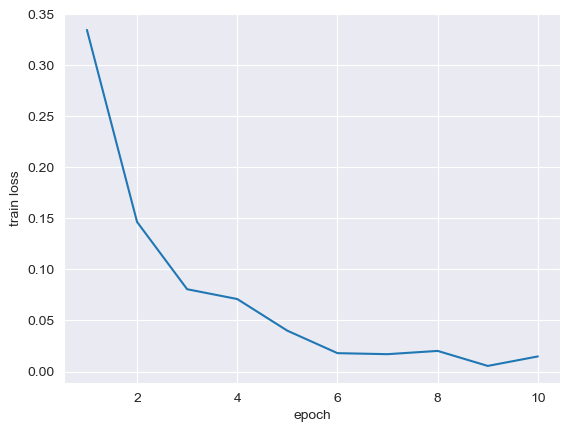

In [16]:
# train loss 그래프
plt.plot(epo_list, train_loss_list)
plt.xlabel('epoch')
plt.ylabel('train loss')
plt.show()

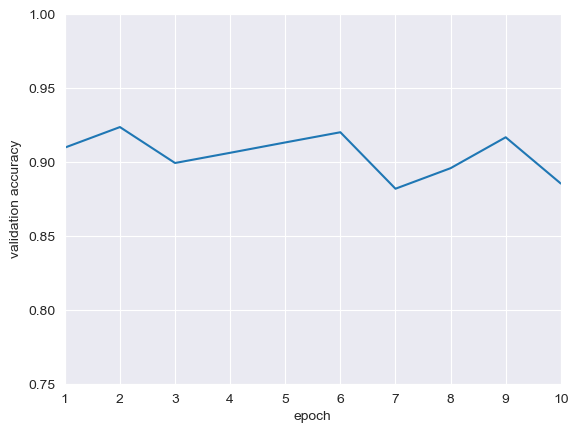

In [17]:
plt.plot(epo_list, val_accuracy_list)
plt.xlabel('epoch')
plt.ylabel('validation accuracy')
plt.axis([1,epochs , 0.75, 1])
plt.show()

In [18]:
#새로운 리뷰를 분류해보자

def test_sentence(sentence):
    # 토큰 ID와 attention mask를 위한 리스트
    test_ids = []
    test_attention_mask = []

    # 전처리
    encoding = preprocessing(sentence, tokenizer)
    test_ids.append(encoding['input_ids'])
    test_attention_mask.append(encoding['attention_mask'])
    test_ids = torch.cat(test_ids, dim = 0)
    test_attention_mask = torch.cat(test_attention_mask, dim = 0)
    
    # Forward pass, calculate logit predictions
    with torch.no_grad():
        output = model(test_ids.to(device), token_type_ids = None, attention_mask = test_attention_mask.to(device))

    prediction = 'Positive' if np.argmax(output.logits.cpu().numpy()).flatten().item() == 1 else 'Negative'
    return prediction
    

    
    
new_sentence ='The food was bad, but it was cheap'
# 'It''s good, but the owner is so unkind. Some of the plates didn''t clean properly because there was something on them. But it''s cost-effective.'





print('입력 문장:', new_sentence)
print('분류:', test_sentence(new_sentence))

입력 문장: The food was bad, but it was cheap
분류: Negative


In [19]:
#test data 세팅

# 내 깃허브 폴더에서 리뷰 데이터 불러와서 dataframe으로 저장
test_url='https://raw.githubusercontent.com/Eunjin3395/graduation_project/main/data/food_test.csv'
df = pd.read_csv(test_url,sep=',', header=0, encoding_errors='ignore')
df.head(5)

,id,text,category,polarity
0,3440,"Even though its good seafood, the prices are t...",aa,1
1,en_CatalRestaurant__UvaBar_477861889:4,My g/f and I both agreed the food was very med...,food,0
2,1242,But the coconut rice was good.,food,1
3,en_BlueRibbonSushi_478218345:2,It has great sushi and even better service.,food,1
4,882,"While the ambiance and atmosphere were great, ...",food,0


In [20]:
count=0

test_text = df.text.values
test_labels = df.polarity.values

for i in range(len(test_labels)):
    t = df.iloc[i].text
    color_s='\033[31m' 
    color_e='\033[0m'
    
    prediction=test_sentence(t)
    if(prediction=="Negative"):
        result=0
    else:
        result=1
        
    if(result==df.iloc[i].polarity):
        count+=1     
        color_s=''
        color_e=''
    print(color_s+"=============================== Input {} ===============================".format(i+1))
    print(t)
    print("model result:",prediction,"\nanswer:", df.iloc[i].polarity,color_e)
    print("")


print("test accuracy: {:.4f}".format(count/len(test_labels)))
    

=============================== Input 1 ===============================
Even though its good seafood, the prices are too high.
model result: Positive 
answer: 1 

=============================== Input 2 ===============================
My g/f and I both agreed the food was very mediocre especially considering the price.
model result: Negative 
answer: 0 

=============================== Input 3 ===============================
But the coconut rice was good.
model result: Positive 
answer: 1 

=============================== Input 4 ===============================
It has great sushi and even better service.
model result: Positive 
answer: 1 

=============================== Input 5 ===============================
While the ambiance and atmosphere were great, the food and service could have been a lot better.
model result: Negative 
answer: 0 

=============================== Input 6 ===============================
The food was lousy -too sweet or too salty and the portions tiny.
model res

=============================== Input 55 ===============================
Anyway, the food is good, the price is right and they have a decent wine list.
model result: Positive 
answer: 1 

=============================== Input 56 ===============================
The bagels are fabulous.
model result: Positive 
answer: 1 

=============================== Input 57 ===============================
All the appetizers and salads were fabulous, the steak was mouth watering and the pasta was delicious!!!
model result: Positive 
answer: 1 

=============================== Input 58 ===============================
I love the fact that the pizza tastes so good and is so cheap.
model result: Positive 
answer: 1 

=============================== Input 59 ===============================
The sushi was awful!
model result: Negative 
answer: 0 

=============================== Input 60 ===============================
I may not be a sushi guru but I can tell you that the food here is just okay and that the